# RCP Simulations



## 1. Loading Dataset & Model

Here we perform some simulation using the Representative Concentration Pathways (RCP) datasets, which include emissions _projections_ (not emissions) which assume variouse mitigating factors for all major anthropogenic greenhouse gases from $1765$ to $2500$. We only consider CO2 emissions for fossil, industrial, and land use-related emissions in the $4$ RCP scenario and its mean. We refer the reader to Meinshausen et al., [The RCP greenhouse gas concentrations and their extensions from 1765 to 2300](https://link.springer.com/article/10.1007/s10584-011-0156-z) for further details. See ``data/source/EmiAndConcData`` for the full source dataset and ``data/emissions`` for the cleaned-up snippet of the dataset that is used for our experiment only.

We load the calibrated model, which has been trained in ``\solver`` and saved in ``\results``. The model equilibrium masses, $\mathbf{m}^{eq}$, have been calibrated to the pre-industrial year which assume to correspond to RCP dataset starting year of $1765$

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable

import lib_operations as operations
import lib_data_load as data_load
from lib_models import model_3sr,model_4pr,model_5pr

_plot_vis={}
_plot_vis['color']  = ['black','red','blue','green','orange','purple','brown','pink']
_plot_vis['style']  = ['solid','dashed','dotted','dashdot']
_plot_vis['marker'] = ['o','v','s','D','X']

make_plot = lambda n,m: plt.subplots(n,m,figsize=(m*4,n*3),squeeze=False,layout='tight')

# shortcut for finding index of given value
inx_find = lambda x, val: int(np.where(x == val)[0])

np.set_printoptions(suppress=True)
plt.rcParams['text.usetex'] = True

# Load data

/Users/aryan/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Text(0.5, 0, 'Year')

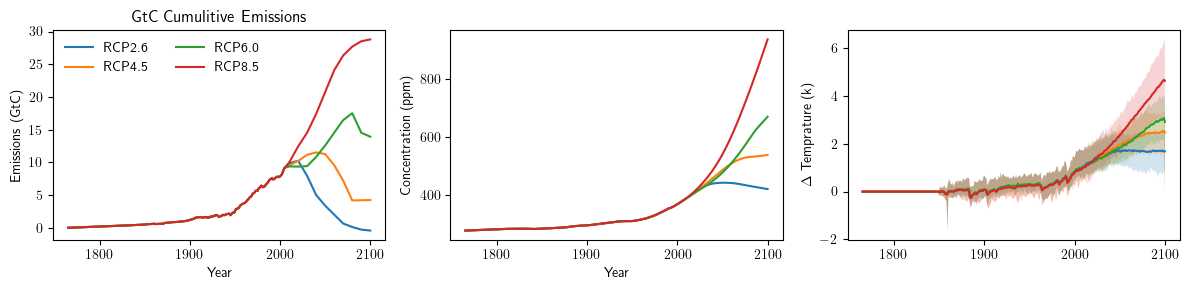

In [22]:
# THE BEST SETTINGS
_root = 'result/new_650/15_1.0x/T-1000_tau-10000/'
_test_name = 'MMMU_MMM_MMMD-0.0_0.0_0.005'
_model_set = [model_3sr,model_4pr]

#Load model results
results = operations.load_results(root=_root,test_name=_test_name,model_set=_model_set)
fig, axs = make_plot(1,3)

for i, scenerio in enumerate(['RCP2.6', 'RCP4.5', 'RCP6.0', 'RCP8.5']):
    
    [data_val,data_year] = data_load.cmip_emission(scenerio_name=scenerio,T_start=1765,T_end=2100)
    axs[0,0].plot(data_year,data_val,label=scenerio)
    
    [data_val,data_year] = data_load.cmip_concentration(scenerio_name=scenerio,T_start=1765,T_end=2100)
    axs[0,1].plot(data_year,data_val,label=scenerio)

    [data_val,data_year] = data_load.cmip_temperature(scenerio_name=scenerio,T_start=1765,T_end=2100)

    
    axs[0,2].plot(data_year,np.mean(data_val,0),label=scenerio)
    axs[0,2].fill_between(data_year,  np.min(data_val,0), np.max(data_val,0), alpha=0.2)
    
   # axs[0,2].plot(data_year,data_val.T,label=scenerio)

axs[0,0].legend(frameon=False,loc='upper left',ncol=2)

axs[0,0].set_ylabel(r'Emissions (GtC)')
axs[0,1].set_ylabel(r'Concentration (ppm)')
axs[0,2].set_ylabel(r'$\Delta$ Temprature (k)')

axs[0,0].set_title(r'GtC Cumulitive Emissions')
                                           
axs[0,0].set_xlabel(r'Year')    
axs[0,1].set_xlabel(r'Year')    

# integrate to current conditions  for Econ Model

In [23]:
# start simulation at 1765
[emissions,years]=data_load.cmip_emission(scenerio_name='RCP8.5',T_start=1765,T_end=2100)
m_at_current = 2.12*421

for model_inx,model_name in enumerate(results.keys()):  
    model = results[model_name]['model'] 
    [_,_,info]= model()
    test_type_set = results[model_name]['test_type_set']

    results[model_name]['m_ini']         =  [0] * len(test_type_set)
    results[model_name]['t_current']     =  [0] * len(test_type_set) 
    results[model_name]['t_current_inx'] =  [0] * len(test_type_set)
    


    for test_type_inx,test_type_name in enumerate(test_type_set):
                
        if test_type_name in ['AVG']:
            continue

        A    = results[model_name]['A'][test_type_inx]
        m_eq = results[model_name]['m_eq'][test_type_inx]
                
        m_sim = []
        m_sim.append(m_eq)
                    
        e = np.zeros(len(m_sim[-1]))
                
        t = 0
        while m_sim[-1][0]< m_at_current:

            e[0]=emissions[t]
            m_sim+=[ A@m_sim[-1] +m_sim[-1] +  e ]

            t+=1

        m_sim=np.array(m_sim).T


        results[model_name]['m_ini'][test_type_inx]         =  np.round(m_sim[:,-1] ,0)  
        results[model_name]['t_current'][test_type_inx]     =  1765+t   
        results[model_name]['t_current_inx'][test_type_inx] = t


        
operations.tabulate(results=results,vars=['m_ini','t_current','t_current_inx'])

import pickle
import copy

results_dump = copy.deepcopy(results)

for model_inx,model_name in enumerate(results_dump.keys()):  
    results_dump[model_name]['model'] = None

# open a file, where you ant to store the data
file = open('test/data_dump.pkl', 'wb')

# dump information to that file
pickle.dump(results_dump, file)

# close the file
file.close()



+------------------------------------------------------------------------------------------------+
|                                             Table                                              |
+-------+------+---------------------+-------------------------------+-----------+---------------+
| model | type |         rho         |             m_ini             | t_current | t_current_inx |
+-------+------+---------------------+-------------------------------+-----------+---------------+
|  3SR  | MMMU | [0.    0.    0.005] |     [  897.  1162. 37117.]    |    2017   |      252      |
|  3SR  | MMM  | [0.    0.    0.005] |     [  894.  1283. 37140.]    |    2028   |      263      |
|  3SR  | MMMD | [0.    0.    0.005] |     [  897.  1282. 37167.]    |    2030   |      265      |
|  4PR  | MMMU | [0.    0.    0.005] | [  893.   997. 37104.   747.] |    2009   |      244      |
|  4PR  | MMM  | [0.    0.    0.005] | [  894.  1065. 37115.   826.] |    2023   |      258      |
|  4PR  | 

# Simulate Postive Pulse at 1765

Text(0.5, 0, '$t (\\textnormal{Years})$')

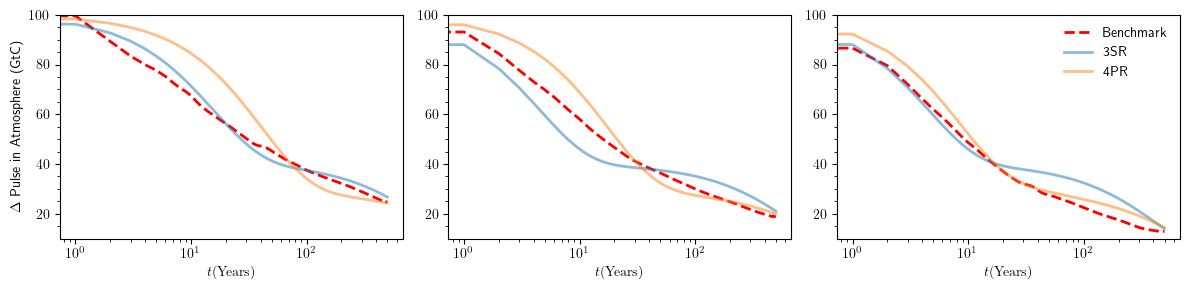

In [24]:
fig, axs = make_plot(1,3)
for model_inx,model_name in enumerate(results.keys()):  
    model = results[model_name]['model'] 
            
    [_,_,info]= model()
    test_type_set = results[model_name]['test_type_set']
                
    for test_type_inx,test_type_name in enumerate(test_type_set):
                
        if test_type_name in ['AVG']:
            continue
 
        A    = results[model_name]['A'][test_type_inx]
        m_eq = results[model_name]['m_eq'][test_type_inx]
        m_ini = results[model_name]['m_ini'][test_type_inx]
                
        T  = 500
        m0 = m_eq       
        e  = np.zeros(T)
                
        e[0]=+100
        [m_sim,_,_]  = operations.simulate(A=A,m_eq=m_eq,m0=m0,T=T,e=e)      
                
        if  model_inx==0:
            [m_benchmark,_] = data_load.pulse_fraction(test_type=test_type_name,T=T) 
            m_benchmark=m_benchmark* e[0] 
                    

            axs[0,test_type_inx].plot(m_benchmark,
                            linewidth=2,
                            alpha=1.0,
                            linestyle='--',
                            color='red',
                            label='Benchmark')
                
        axs[0,test_type_inx].semilogx(m_sim[0,:]-m_eq[0],
                        linewidth=2,
                        alpha=0.5,
                        label=model_name)
        axs[0,test_type_inx].minorticks_on()
        axs[0,test_type_inx].set_ylim(bottom=10, top=100)

axs[0,2].legend(frameon=False,loc='upper right',ncol=1)

axs[0,0].set_ylabel(r'$\Delta$ Pulse in Atmosphere (GtC)')
                                           
axs[0,0].set_xlabel(r'$t (\textnormal{Years})$')        
axs[0,1].set_xlabel(r'$t (\textnormal{Years})$')    
axs[0,2].set_xlabel(r'$t (\textnormal{Years})$')      

# Simulate Negative Pulse at 1765

Text(0.5, 0, '$t (\\textnormal{Years})$')

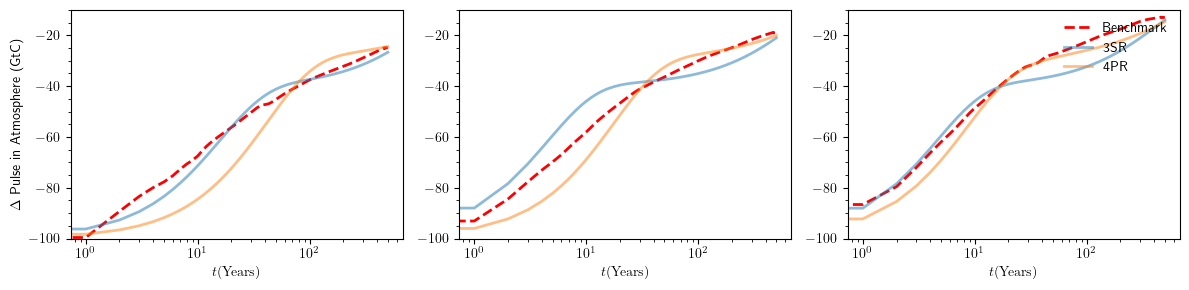

In [25]:
fig, axs = make_plot(1,3)
for model_inx,model_name in enumerate(results.keys()):  
    model = results[model_name]['model'] 
            
    [_,_,info]= model()
    test_type_set = results[model_name]['test_type_set']
                
    for test_type_inx,test_type_name in enumerate(test_type_set):
                
        if test_type_name in ['AVG']:
            continue
 
        A    = results[model_name]['A'][test_type_inx]
        m_eq = results[model_name]['m_eq'][test_type_inx]
        m_ini = results[model_name]['m_ini'][test_type_inx]
                
        T  = 500
        m0 = m_eq       
        e  = np.zeros(T)
                
        e[0]=-100
        [m_sim,_,_]  = operations.simulate(A=A,m_eq=m_eq,m0=m0,T=T,e=e)

                
        if  model_inx==0:
            [m_benchmark,_] = data_load.pulse_fraction(test_type=test_type_name,T=T) 
            m_benchmark=m_benchmark* e[0]
                    
            axs[0,test_type_inx].plot(m_benchmark,
                            linewidth=2,
                            alpha=1.0,
                            linestyle='--',
                            color='red',
                            label='Benchmark')
                
        axs[0,test_type_inx].semilogx(m_sim[0,:]-m_eq[0],
                        linewidth=2,
                        alpha=0.5,
                        label=model_name)
        axs[0,test_type_inx].minorticks_on()
        axs[0,test_type_inx].set_ylim(bottom=-100, top=-10)

axs[0,2].legend(frameon=False,loc='upper right',ncol=1)

axs[0,0].set_ylabel(r'$\Delta$ Pulse in Atmosphere (GtC)')
                                           
axs[0,0].set_xlabel(r'$t (\textnormal{Years})$')        
axs[0,1].set_xlabel(r'$t (\textnormal{Years})$')    
axs[0,2].set_xlabel(r'$t (\textnormal{Years})$')      

# CMIP Concentrations 

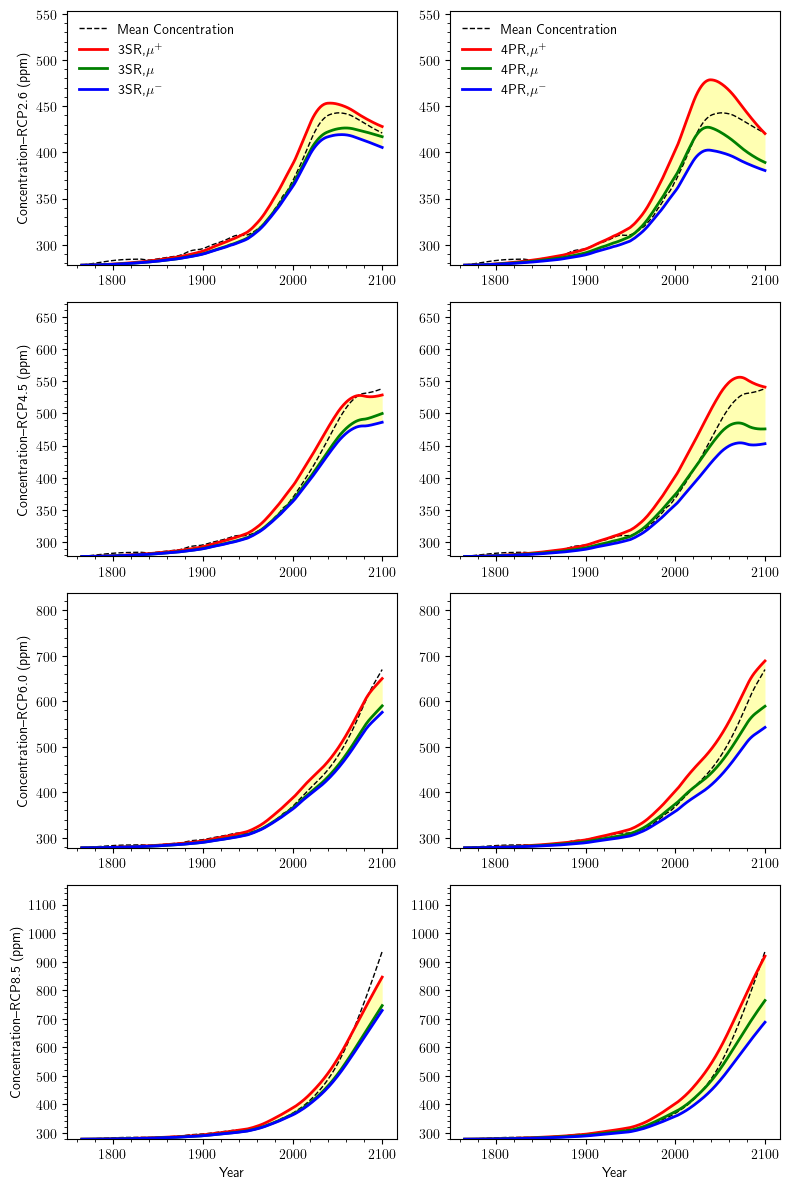

In [26]:

scenerio_set =['RCP2.6', 'RCP4.5', 'RCP6.0', 'RCP8.5']

m_conc_sim_set    = [0]*len(scenerio_set)
cmip_data_set     = [0]*(len(scenerio_set)+1)
    
for i, scenerio in enumerate(scenerio_set):

    [emis_val,emis_year] = data_load.cmip_emission(scenerio_name=scenerio,T_start=1765,T_end=2100)        
    [conc_val,conc_year] = data_load.cmip_concentration(scenerio_name=scenerio,T_start=1765,T_end=2100)
    [temp_val,temp_year] = data_load.cmip_temperature(scenerio_name=scenerio,T_start=1765,T_end=2100)

    m_conc_sim_set[i]=[0]*len(results.keys())

    cmip_data_set[i] = conc_val
    cmip_data_set[-1] = conc_year

    for model_inx,model_name in enumerate(results.keys()):  
        model      = results[model_name]['model']     
        [_,_,info] = model()
        test_type_set = results[model_name]['test_type_set']
        
        m_conc_sim_set[i][model_inx]=[0]*(len(test_type_set)-1)
                
        for test_type_inx,test_type_name in enumerate(test_type_set):
                    
            if test_type_name in ['AVG']   :
                continue
    
            A       = results[model_name]['A'][test_type_inx]
            m_eq    = results[model_name]['m_eq'][test_type_inx]
            
            T       = len(emis_val)
            m0      = m_eq
            
            [m_sim,temp_at,temp_o]  = operations.simulate(A=A,m_eq=m_eq,m0=m0,T=T,e=emis_val)
                    
            m_conc_sim = m_sim[0,:]/2.12

            m_conc_sim_set[i][model_inx][test_type_inx] = m_conc_sim

fig, axs = make_plot(len(m_conc_sim_set),len(m_conc_sim_set[0]))
model_name_set = list(results.keys())
for scenerio_inx in range(0,len(m_conc_sim_set)):
    for model_inx in range(0,len(m_conc_sim_set[scenerio_inx])):
        axs[scenerio_inx,model_inx].plot(cmip_data_set[-1],cmip_data_set[scenerio_inx],linewidth=1,alpha=1,color='black',linestyle='--',label='Mean Concentration')
        axs[scenerio_inx,model_inx].plot(cmip_data_set[-1],m_conc_sim_set[scenerio_inx][model_inx][0], linewidth=2,alpha=1, label = (model_name_set[model_inx]  +r',$\mu^+$'),color='red') 
        axs[scenerio_inx,model_inx].plot(cmip_data_set[-1],m_conc_sim_set[scenerio_inx][model_inx][1], linewidth=2,alpha=1,  label = (model_name_set[model_inx] +r',$\mu$'),color='green') 
        axs[scenerio_inx,model_inx].plot(cmip_data_set[-1],m_conc_sim_set[scenerio_inx][model_inx][2], linewidth=2,alpha=1, label = (model_name_set[model_inx]  +r',$\mu^-$'),color='blue')  

        axs[scenerio_inx,model_inx].fill_between(cmip_data_set[-1],m_conc_sim_set[scenerio_inx][model_inx][0] ,m_conc_sim_set[scenerio_inx][model_inx][-1] , linewidth=0,alpha=0.3, label='_ignore',color='yellow')  
        axs[scenerio_inx,model_inx].minorticks_on()
        axs[scenerio_inx,model_inx].set_ylim(bottom=np.min(cmip_data_set[scenerio_inx]*1), top=np.max(cmip_data_set[scenerio_inx]*1.25))

for i in range (0,len(_model_set)):
    axs[0,i].legend(frameon=False,loc='upper left',ncol=1)
    axs[3,i].set_xlabel(r'Year') 

axs[0,0].set_ylabel(r'Concentration--RCP2.6 (ppm)')
axs[1,0].set_ylabel(r'Concentration--RCP4.5 (ppm)')
axs[2,0].set_ylabel(r'Concentration--RCP6.0 (ppm)')
axs[3,0].set_ylabel(r'Concentration--RCP8.5 (ppm)')

fig.savefig('doc/fig/simulate_cmip_conc.png', dpi=300)

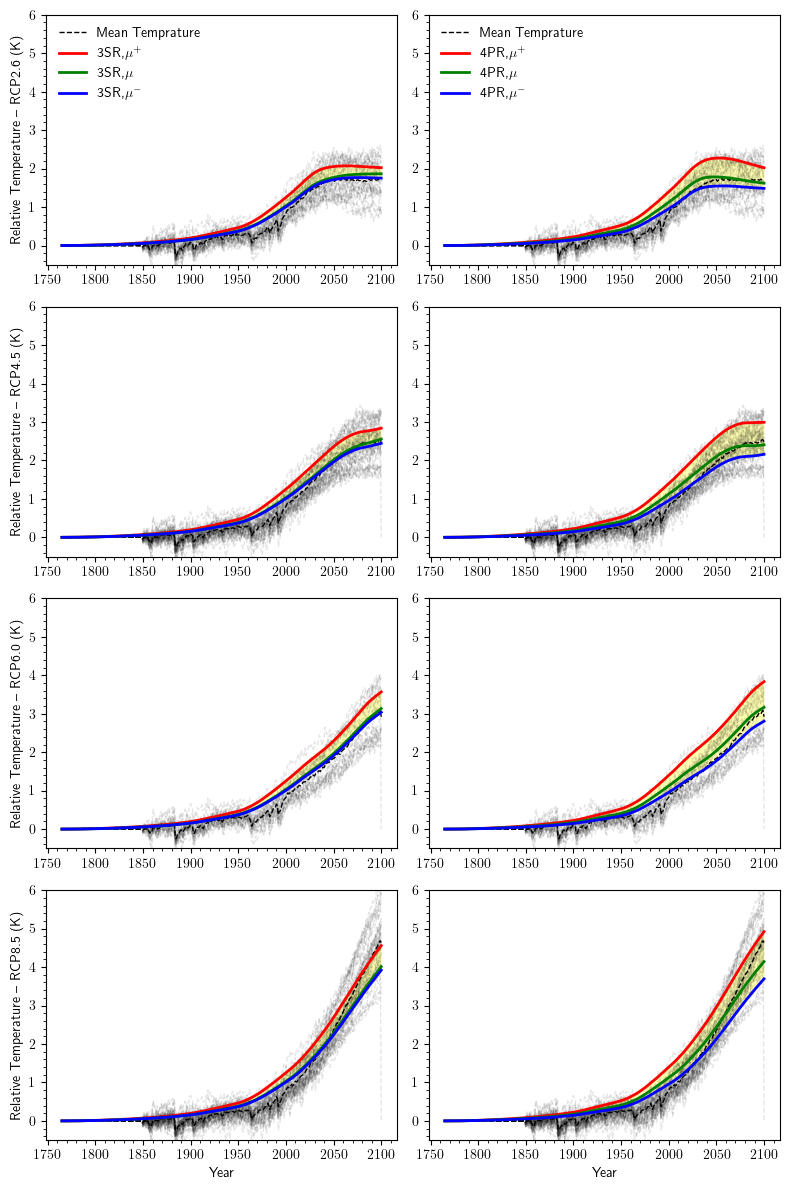

In [27]:

scenerio_set =['RCP2.6', 'RCP4.5', 'RCP6.0', 'RCP8.5']

temp_sim_set    = [0]*len(scenerio_set)
cmip_data_set   = [0]*(len(scenerio_set)+1)
    
for i, scenerio in enumerate(scenerio_set):

    [emis_val,emis_year] = data_load.cmip_emission(scenerio_name=scenerio,T_start=1765,T_end=2100)        
    [conc_val,conc_year] = data_load.cmip_concentration(scenerio_name=scenerio,T_start=1765,T_end=2100)
    [temp_val,temp_year] = data_load.cmip_temperature(scenerio_name=scenerio,T_start=1765,T_end=2100)

    temp_sim_set[i]=[0]*len(results.keys())

    cmip_data_set[i] = temp_val
    cmip_data_set[-1] = conc_year

    for model_inx,model_name in enumerate(results.keys()):  
        model      = results[model_name]['model']     
        [_,_,info] = model()
        test_type_set = results[model_name]['test_type_set']
        
        temp_sim_set[i][model_inx]=[0]*(len(test_type_set)-1)
                
        for test_type_inx,test_type_name in enumerate(test_type_set):
                    
            if test_type_name in ['AVG']   :
                continue

            A       = results[model_name]['A'][test_type_inx]

            #A       = results[model_name]['A'][test_type_inx]
            m_eq    = results[model_name]['m_eq'][test_type_inx]
            
            T       = len(emis_val)
            m0      = m_eq
            
            [m_sim,temp_at,temp_o]  = operations.simulate(A=A,m_eq=m_eq,m0=m0,T=T,e=emis_val)

            temp_sim_set[i][model_inx][test_type_inx] = temp_at


fig, axs = make_plot(len(temp_sim_set),len(temp_sim_set[0]))
model_name_set = list(results.keys())
for scenerio_inx in range(0,len(temp_sim_set)):
    for model_inx in range(0,len(temp_sim_set[scenerio_inx])):

        axs[scenerio_inx,model_inx].plot(cmip_data_set[-1],cmip_data_set[scenerio_inx].T,linewidth=1,alpha=.1,color='black',linestyle='--')
        axs[scenerio_inx,model_inx].plot(cmip_data_set[-1],np.mean(cmip_data_set[scenerio_inx].T,1),linewidth=1,alpha=1,color='black',linestyle='--',label='Mean Temprature')

        axs[scenerio_inx,model_inx].plot(cmip_data_set[-1],temp_sim_set[scenerio_inx][model_inx][0], linewidth=2,alpha=1, label = (model_name_set[model_inx]+r',$\mu^+$'),color='red') 
        axs[scenerio_inx,model_inx].plot(cmip_data_set[-1],temp_sim_set[scenerio_inx][model_inx][1], linewidth=2,alpha=1, label = (model_name_set[model_inx]+r',$\mu$')    ,color='green') 
        axs[scenerio_inx,model_inx].plot(cmip_data_set[-1],temp_sim_set[scenerio_inx][model_inx][2], linewidth=2,alpha=1, label = (model_name_set[model_inx]+r',$\mu^-$'),color='blue')  

        axs[scenerio_inx,model_inx].fill_between(cmip_data_set[-1],temp_sim_set[scenerio_inx][model_inx][0] ,temp_sim_set[scenerio_inx][model_inx][-1] , linewidth=0,alpha=0.3, label='_ignore',color='yellow')  
        axs[scenerio_inx,model_inx].minorticks_on()
        axs[scenerio_inx,model_inx].set_ylim(bottom=-0.5, top=6)

for i in range (0,len(_model_set)):
    axs[0,i].legend(frameon=False,loc='upper left',ncol=1)
    axs[3,i].set_xlabel(r'Year')  

axs[0,0].set_ylabel(r'Relative Temperature -- RCP2.6 (K)')
axs[1,0].set_ylabel(r'Relative Temperature -- RCP4.5 (K)')
axs[2,0].set_ylabel(r'Relative Temperature -- RCP6.0 (K)')
axs[3,0].set_ylabel(r'Relative Temperature -- RCP8.5 (K)')              
  
fig.savefig('doc/fig/simulate_cmip_temp.png', dpi=300)

# Temp From CMIP Concentration

Text(0, 0.5, 'Concentration--RCP8.5 (ppm)')

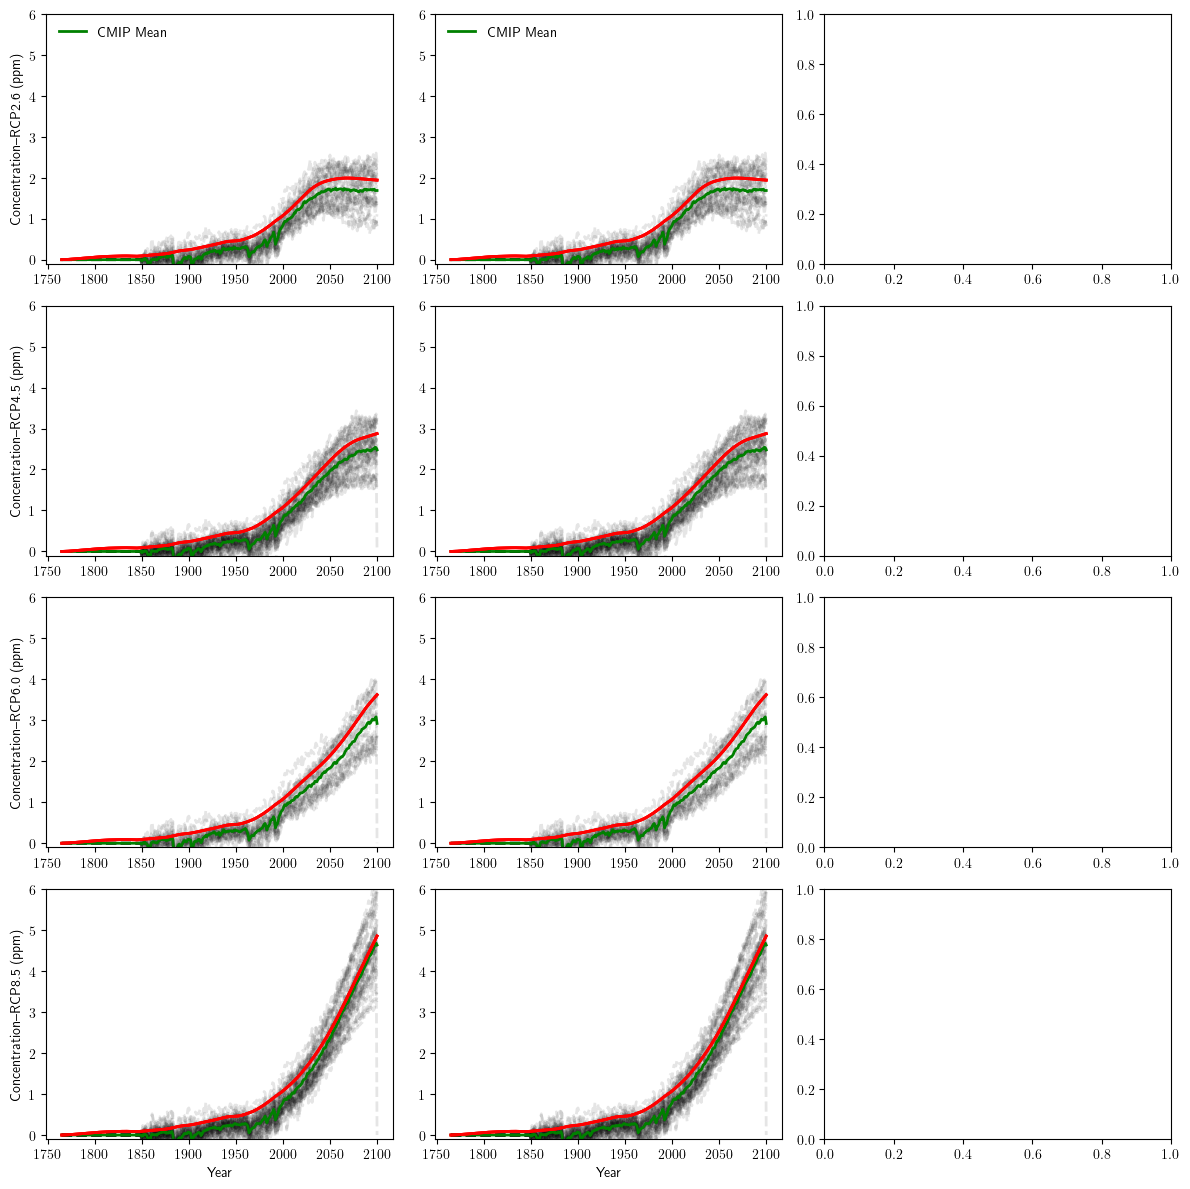

In [28]:
fig, axs = make_plot(4,3)
model_name_set = list(results.keys())
for scenerio_inx in range(0,4):
    for model_inx,model_name in enumerate(results.keys()):  

        [emis_val,emis_year] = data_load.cmip_emission(scenerio_name=scenerio_set[scenerio_inx],T_start=1765,T_end=2100)        
        [conc_val,conc_year] = data_load.cmip_concentration(scenerio_name=scenerio_set[scenerio_inx],T_start=1765,T_end=2100)
        [temp_val,temp_year] = data_load.cmip_temperature(scenerio_name=scenerio_set[scenerio_inx],T_start=1765,T_end=2100)


        axs[scenerio_inx,model_inx].plot(temp_year,temp_val.T,linewidth=2,alpha=.1,color='black',linestyle='--')
        axs[scenerio_inx,model_inx].plot(temp_year,np.mean(temp_val.T,1),linewidth=2,alpha=1,color='green',linestyle='-',label='CMIP Mean')

        for test_type_inx,test_type_name in enumerate(test_type_set):
                        
            if test_type_name in ['AVG']   :
                continue
        

            if test_type_inx==0:
                A       = results[model_name]['A'][0]/2 + results[model_name]['A'][1]/2
            
            else:
                A       = results[model_name]['A'][test_type_inx]

            m_eq    = results[model_name]['m_eq'][test_type_inx]
                
            T       = len(conc_val)
            m0      = m_eq
                
            [temp_at,temp_o]  = operations.test_temp(conc_val*2.12)

            axs[scenerio_inx,model_inx].plot(conc_year,temp_at,linewidth=2,alpha=1,color='red',linestyle='-')

        #axs[scenerio_inx,model_inx].plot(cmip_data_set[-1],temp_sim_set[scenerio_inx][model_inx][0], linewidth=2,alpha=1, label = (model_name_set[model_inx]+r' MMM$^{+}$'),color='red') 
        #axs[scenerio_inx,model_inx].plot(cmip_data_set[-1],temp_sim_set[scenerio_inx][model_inx][1], linewidth=2,alpha=1, label = (model_name_set[model_inx]+r' MMM')    ,color='blue') 
        #axs[scenerio_inx,model_inx].plot(cmip_data_set[-1],temp_sim_set[scenerio_inx][model_inx][2], linewidth=2,alpha=1, label = (model_name_set[model_inx]+r' MMM$^{-}$'),color='green')  

        #axs[scenerio_inx,model_inx].fill_between(cmip_data_set[-1],temp_sim_set[scenerio_inx][model_inx][0] ,temp_sim_set[scenerio_inx][model_inx][-1] , linewidth=0,alpha=0.3, label='_ignore',color='yellow')  
        #axs[scenerio_inx,model_inx].minorticks_on()
        axs[scenerio_inx,model_inx].set_ylim(bottom=-0.1, top=6)

for i in range (0,len(_model_set)):
    axs[0,i].legend(frameon=False,loc='upper left',ncol=1)
    axs[3,i].set_xlabel(r'Year')  

axs[0,0].set_ylabel(r'Concentration--RCP2.6 (ppm)')
axs[1,0].set_ylabel(r'Concentration--RCP4.5 (ppm)')
axs[2,0].set_ylabel(r'Concentration--RCP6.0 (ppm)')
axs[3,0].set_ylabel(r'Concentration--RCP8.5 (ppm)')

# MacDougall

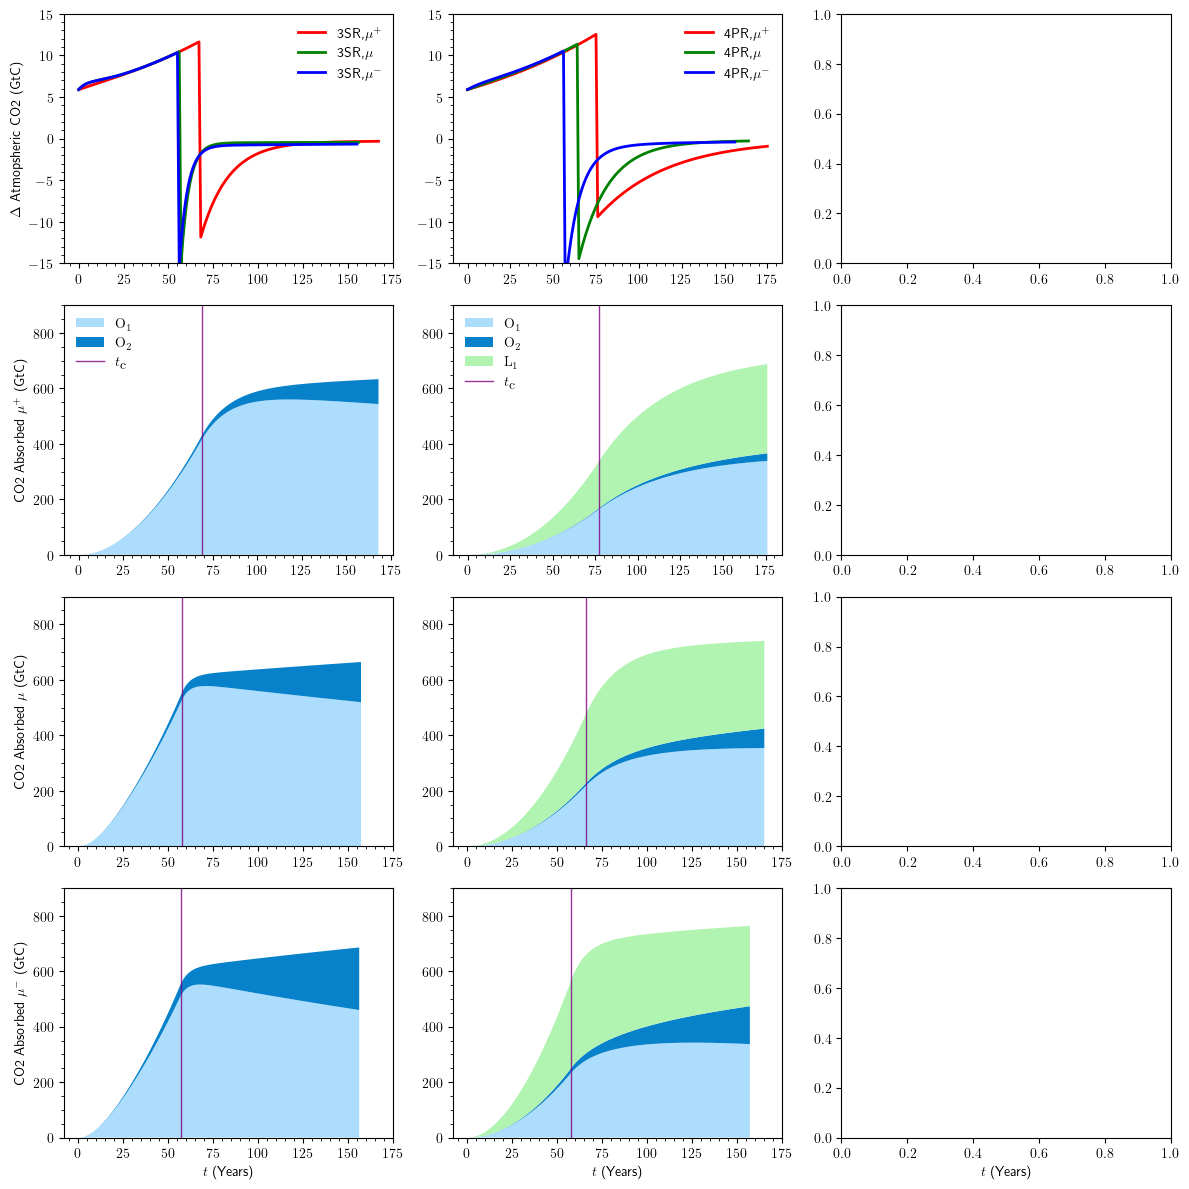

In [29]:
T_mac_dougall = 100
m_sim_set            = [0]*len(results.keys())
temp_sim_set         = [0]*len(results.keys())
T_stop_emissions_set = [0]*len(results.keys())

for model_inx,model_name in enumerate(results.keys()):  
    
        model = results[model_name]['model'] 
        [_,_,info]= model()
        test_type_set = results[model_name]['test_type_set']

        m_sim_set[model_inx]            = [0]*len(test_type_set)
        temp_sim_set[model_inx]         = [0]*len(test_type_set)
        T_stop_emissions_set[model_inx] = [0]*len(test_type_set)
            
        for test_type_inx,test_type_name in enumerate(test_type_set):
                if test_type_name in ['AVG']:
                        continue

                A     = results[model_name]['A'][test_type_inx]
                m_eq  = results[model_name]['m_eq'][test_type_inx]
                m_sim = [m_eq]
                e     = [0]
                
                # produce emission such that we increase CO2 by 1% per year and stop when we have 1000 GTC carbon
                while np.sum(e)<1000*.99:

                    # m_new = Am + m + e
                    # 1.01  = m_new/m = (Am + m)/m + e/m
                    # e/m   = (1.01 - (Am - m)/m)
                    # e     = (1.01*m - Am - m) = (m*(1.01-1) - Am)= (0.01*m-Am)
                    
                    m  = np.copy(m_sim[-1])
                    Am = A@m

                    # compute emissions to get 1% increase
                    e     += [1.0/100.0 * m[0] - Am[0]]
                    m[0]  += e[-1] 
                    m_sim += [Am + m ] 
     
                T_stop_emissions = len(e)

                T_stop_emissions_set[model_inx][test_type_inx] = T_stop_emissions

                e = e + [0]*T_mac_dougall
                [m_sim,temprature_at, temprature_oc]   = operations.simulate(A=A, m_eq=m_eq, m0=m_eq, T=len(e), e=e)
                
                m_sim_set[model_inx][test_type_inx]    = m_sim
                temp_sim_set[model_inx][test_type_inx] = temprature_at
            
fig, axs = make_plot(4,3)
color_set =[(0.6743529411764707, 0.8670274509803922, 0.9864313725490196), (0.03321568627450988, 0.5048784313725492, 0.7971764705882353), (0.6946139705882354, 0.9532291666666667, 0.6946139705882354), (0.10942708333333329, 0.7144944852941177, 0.10942708333333329)]

model_names = ['3SR','4PR','5PR']

for i in range(0,len(m_sim_set)):

        # Plot Delta Atm
        m_sim = m_sim_set[i][0]
        data  = np.copy(m_sim)
        data  = np.diff(data[0,:])
        axs[0,i].plot(data,linewidth=2,alpha=1,label=model_names[i]+r',$\mu^{+}$',color='red') 

        m_sim = m_sim_set[i][1]
        data  = np.copy(m_sim)
        data  = np.diff(data[0,:])
        axs[0,i].plot(data,linewidth=2,alpha=1,label=model_names[i]+r',$\mu$',color='green') 

        m_sim = m_sim_set[i][2]
        data  = np.copy(m_sim)
        data  = np.diff(data[0,:])
        axs[0,i].plot(data,linewidth=2,alpha=1,label=model_names[i]+r',$\mu^{-}$',color='blue') 
        
        axs[0,i].set_xticks(np.arange(0, 200, 25))
        axs[0,i].set_ylim(-15,15)
        axs[0,i].minorticks_on()
        axs[0,i].legend(frameon=False,loc='upper right',ncol=1)

        # plot Upper
        m_sim            = m_sim_set[i][0][1:,:]
        T_stop_emissions = T_stop_emissions_set[i][0]
        p,T              = m_sim.shape
        data             = np.copy(m_sim)

        for j in range(0,p):
                data[j,:] = data[j,:] - m_sim[j,0]

        axs[1,i].stackplot(range(0,T),data,colors=color_set[0:p])
        axs[1,i].axvline(x=T_stop_emissions,color='purple',alpha=0.8,linewidth=1)
        axs[1,i].set_ylim(0,900)
        axs[1,i].minorticks_on()
        axs[1,i].set_xticks(np.arange(0, 200, 25))

        # plot Mid
        m_sim            = m_sim_set[i][1][1:,:]
        T_stop_emissions = T_stop_emissions_set[i][1]
        p,T              = m_sim.shape
        data             = np.copy(m_sim)

        for j in range(0,p):
                data[j,:] = data[j,:] - m_sim[j,0]

        axs[2,i].stackplot(range(0,T),data,colors=color_set[0:p])
        axs[2,i].axvline(x=T_stop_emissions,color='purple',alpha=0.8,linewidth=1)
        axs[2,i].set_ylim(0,900)
        axs[2,i].minorticks_on()
        axs[2,i].set_xticks(np.arange(0, 200, 25))

        # plot Low
        m_sim            = m_sim_set[i][2][1:,:]
        T_stop_emissions = T_stop_emissions_set[i][2]
        p,T              = m_sim.shape
        data             = np.copy(m_sim)
        for j in range(0,p):
                data[j,:] = data[j,:] - m_sim[j,0]

        axs[3,i].stackplot(range(0,T),data,colors=color_set[0:p])
        axs[3,i].axvline(x=T_stop_emissions,color='purple',alpha=0.8,linewidth=1)
        axs[3,i].set_ylim(0,900)
        axs[3,i].minorticks_on()
        axs[3,i].set_xticks(np.arange(0, 200, 25))

axs[0,0].set_ylabel(r'$\Delta$ Atmopsheric CO2 (GtC)')
axs[1,0].set_ylabel(r'CO2 Absorbed $\mu^+$ (GtC)')
axs[2,0].set_ylabel(r'CO2 Absorbed $\mu$ (GtC)')
axs[3,0].set_ylabel(r'CO2 Absorbed $\mu^-$ (GtC)')

axs[-1,0].set_xlabel(r'$t$ (Years)')       
axs[-1,1].set_xlabel(r'$t$ (Years)')      
axs[-1,2].set_xlabel(r'$t$ (Years)') 

axs[1,0].legend([r'$\textrm{O}_1$',r'$\textrm{O}_2$',r'$t_{\textrm{c}}$'],frameon=False,loc='upper left',ncol=1)
axs[1,1].legend([r'$\textrm{O}_1$',r'$\textrm{O}_2$',r'$\textrm{L}_1$',r'$t_{\textrm{c}}$'],frameon=False,loc='upper left',ncol=1)
axs[1,2].legend([r'$\textrm{O}_1$',r'$\textrm{O}_2$',r'$\textrm{L}_1$',r'$\textrm{L}_2$',r'$t_{\textrm{c}}$'],frameon=False,loc='upper left',ncol=1)

fig.savefig('doc/fig/simulate_macdougall_1.png', dpi=300)

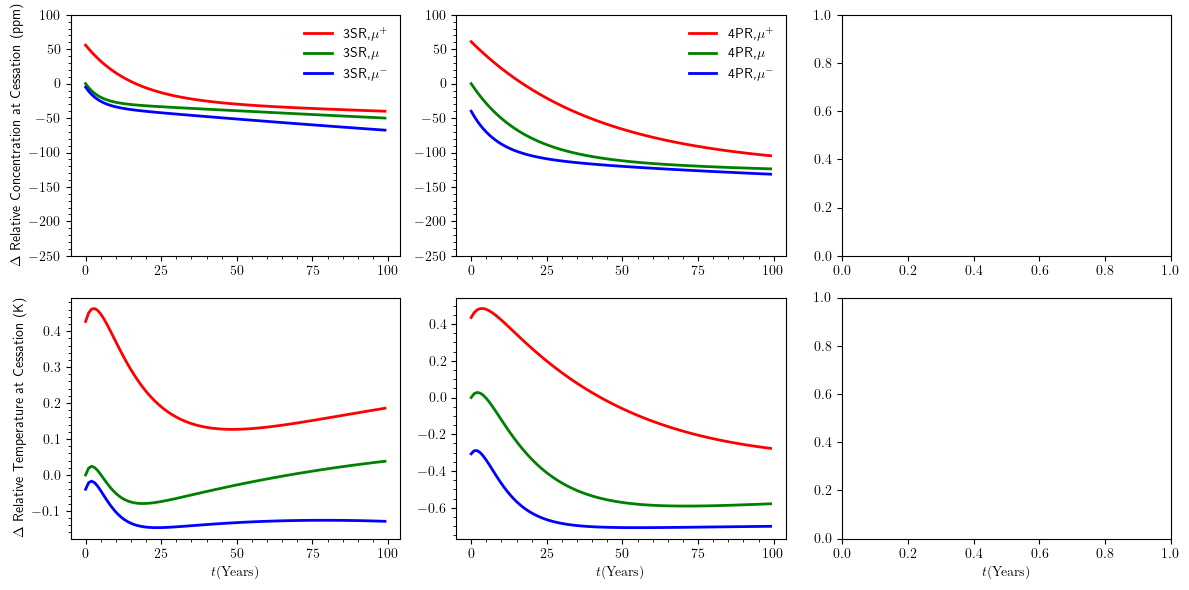

In [30]:
fig, axs = make_plot(2,3)
model_names = ['3SR','4PR','5PR']
for i in range(0,len(m_sim_set)):

        #masses
        m_center = m_sim_set[i][1][0,T_stop_emissions_set[i][1]]

        m_sim = m_sim_set[i][0]
        data  = np.copy(m_sim)
        T_stop_emissions = T_stop_emissions_set[i][0]
        data = data[0,T_stop_emissions:] -m_center
        data = data/2.12
        axs[0,i].plot(data,linewidth=2,alpha=1, label = (model_names[i]+r',$\mu^{+}$'),color='red') 
        axs[0,i].set_xticks(np.arange(0, T_mac_dougall+1, 25))
        axs[0,i].minorticks_on()


        m_sim = m_sim_set[i][1]
        data  = np.copy(m_sim)
        T_stop_emissions = T_stop_emissions_set[i][1] 
        data = data[0,T_stop_emissions:] -m_center
        data = data/2.12
        axs[0,i].plot(data,linewidth=2,alpha=1, label = (model_names[i]+r',$\mu$'),color='green') 
        axs[0,i].set_xticks(np.arange(0, T_mac_dougall+1, 25))
        axs[0,i].minorticks_on()
        
        m_sim = m_sim_set[i][2]
        data  = np.copy(m_sim)
        T_stop_emissions = T_stop_emissions_set[i][2]
        data = data[0,T_stop_emissions:]-m_center
        data = data/2.12
        axs[0,i].plot(data,linewidth=2,alpha=1, label = (model_names[i]+r',$\mu^{-}$'),color='blue') 
        axs[0,i].set_xticks(np.arange(0, T_mac_dougall+1, 25))
        axs[0,i].minorticks_on()

        axs[0,i].set_ylim(-250,100)
        axs[0,i].legend(frameon=False,loc='upper right',ncol=1)

        # TEmp
        t_center = temp_sim_set[i][1][T_stop_emissions_set[i][1]]

        temp_sim         = temp_sim_set[i][0]
        data             = np.copy(temp_sim)
        T_stop_emissions = T_stop_emissions_set[i][0] 
        data             = data[T_stop_emissions:]-t_center
        axs[1,i].plot(data,linewidth=2,alpha=1, label = (model_name+r',$\mu^{+}$'),color='red') 
        axs[1,i].set_xticks(np.arange(0, T_mac_dougall+1, 25))
        axs[1,i].minorticks_on()

        temp_sim         = temp_sim_set[i][1]
        data             = np.copy(temp_sim)
        T_stop_emissions = T_stop_emissions_set[i][1]
        data             = data[T_stop_emissions:]-t_center
        axs[1,i].plot(data,linewidth=2,alpha=1, label = (model_name+r',$\mu$'),color='green') 
        axs[1,i].set_xticks(np.arange(0, T_mac_dougall+1, 25))
        axs[1,i].minorticks_on()

        temp_sim            = temp_sim_set[i][2]
        data             = np.copy(temp_sim)
        T_stop_emissions = T_stop_emissions_set[i][2] 
        data             = data[T_stop_emissions:]-t_center
        axs[1,i].plot(data,linewidth=2,alpha=1, label = (model_name+r',$\mu^{-}$'),color='blue') 
        axs[1,i].set_xticks(np.arange(0, T_mac_dougall+1, 25))
        axs[1,i].minorticks_on()


axs[0,0].set_ylabel(r'$\Delta$ Relative Concentration at Cessation (ppm)')
axs[1,0].set_ylabel(r'$\Delta$ Relative Temperature at Cessation (K)')

axs[-1,0].set_xlabel(r'$t (\textnormal{Years})$')       
axs[-1,1].set_xlabel(r'$t (\textnormal{Years})$')      
axs[-1,2].set_xlabel(r'$t (\textnormal{Years})$')  


fig.savefig('doc/fig/simulate_macdougall_2.png', dpi=300)